Set Directories

In [15]:
# Set the working directory to the base of the repo
base_dir = '/monfs01/projects/ys68/XRD_phase_analysis'

# Replace with your actual data directory
data_dir = "/TOPAS_sim/simulations/batch_20241010_212052_NumSims10000/processed_data"  

Imports

In [16]:
import torch
import numpy as np
import pandas as pd
import math
import json
import os

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

os.chdir(base_dir)
from src.data_loading.TOPASXRD_data_loader import create_data_loaders
import scripts.training.config_training as config_training

%matplotlib inline
plt.style.use('seaborn-v0_8')

Load Training Data

In [17]:
# Load intensities
intensities = np.load(os.path.join(data_dir, 'intensities.npy'))

# Load weight fractions
weight_fractions = pd.read_csv(os.path.join(data_dir, 'weight_fractions.csv'))

# Load additional parameters
additional_params = pd.read_csv(os.path.join(data_dir, 'all_params.csv'))

# Load metadata
with open(os.path.join(data_dir, 'metadata.json'), 'r') as f:
    metadata = json.load(f)

print(f"Loaded {len(intensities)} XRD patterns")
print(f"Shape of intensities array: {intensities.shape}")

FileNotFoundError: [Errno 2] No such file or directory: '/TOPAS_sim/simulations/batch_20241010_212052_NumSims10000/processed_data/intensities.npy'

Display three random XRD sims

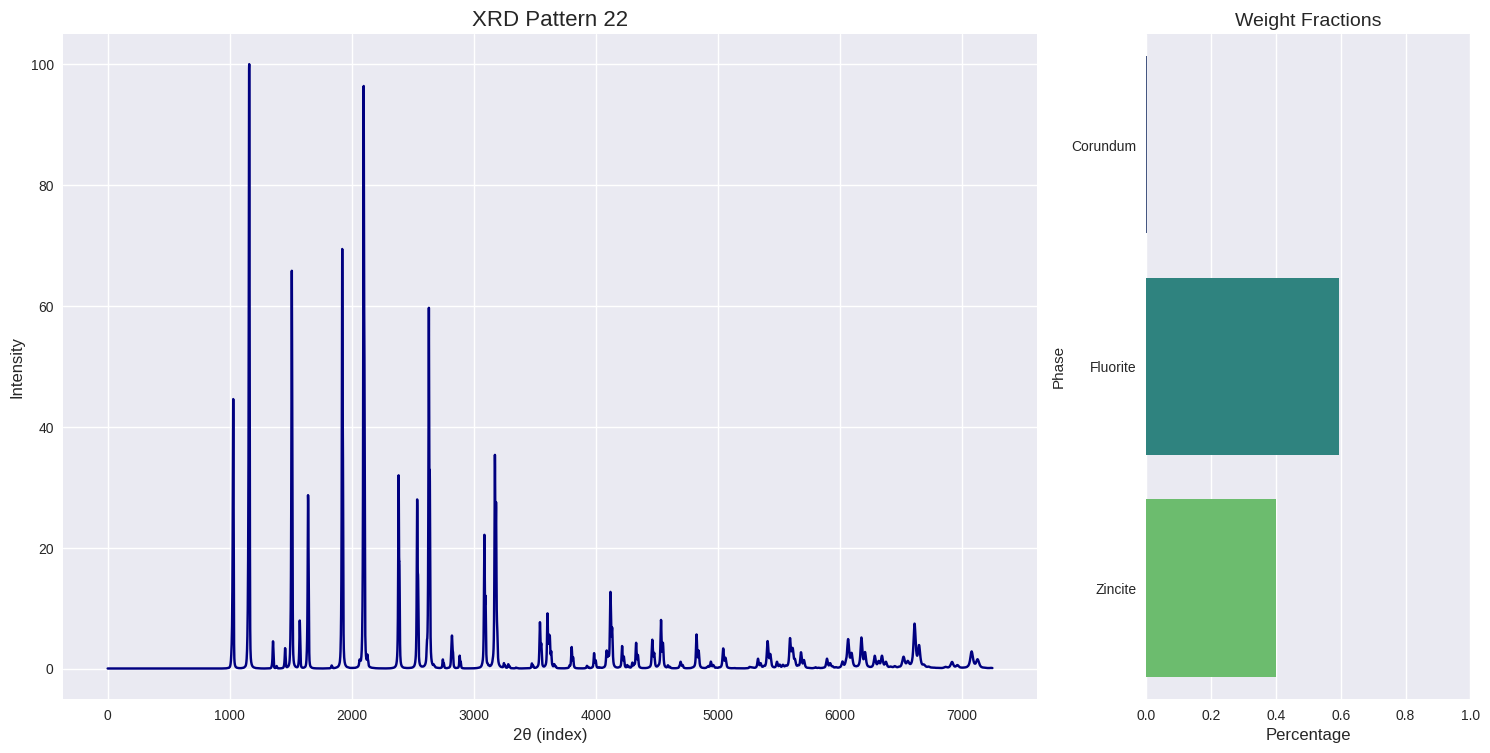

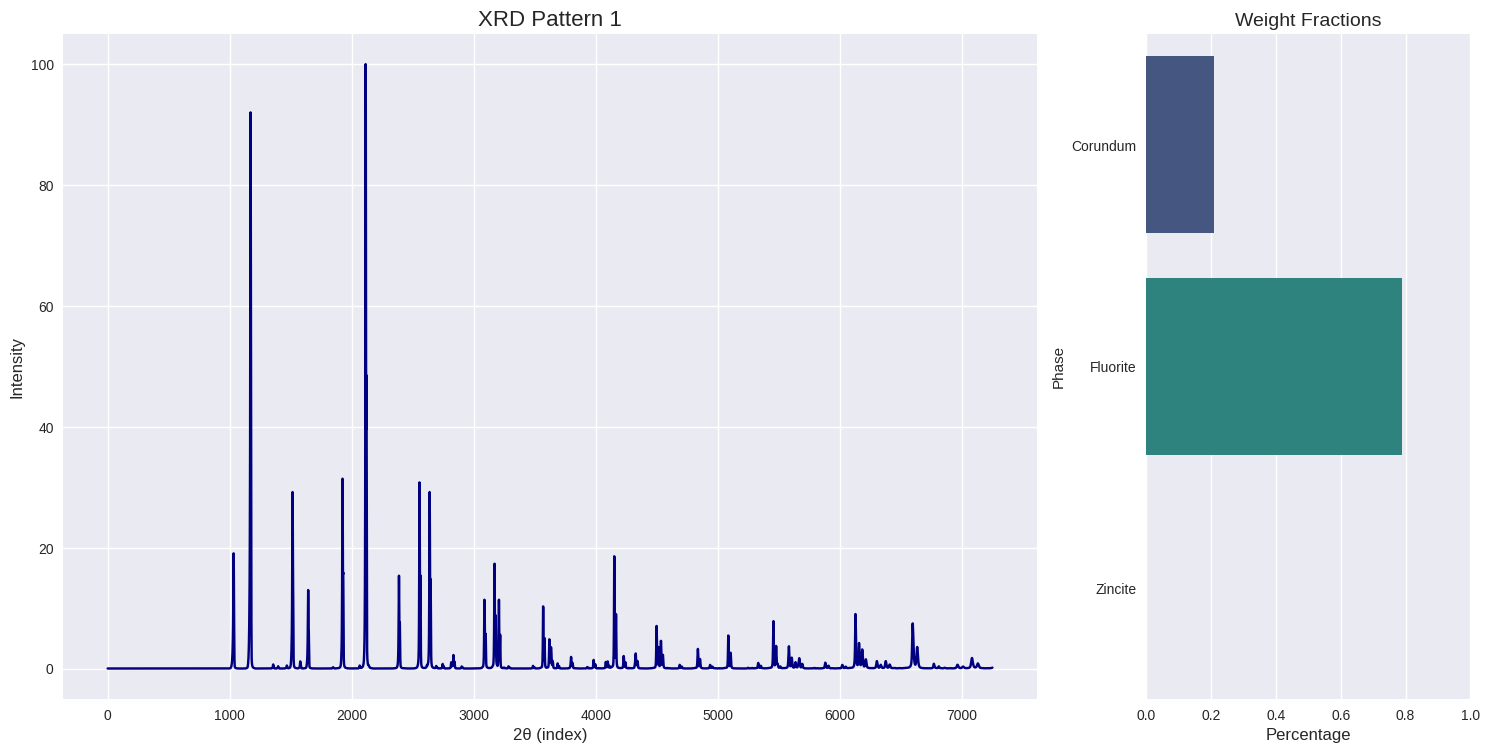

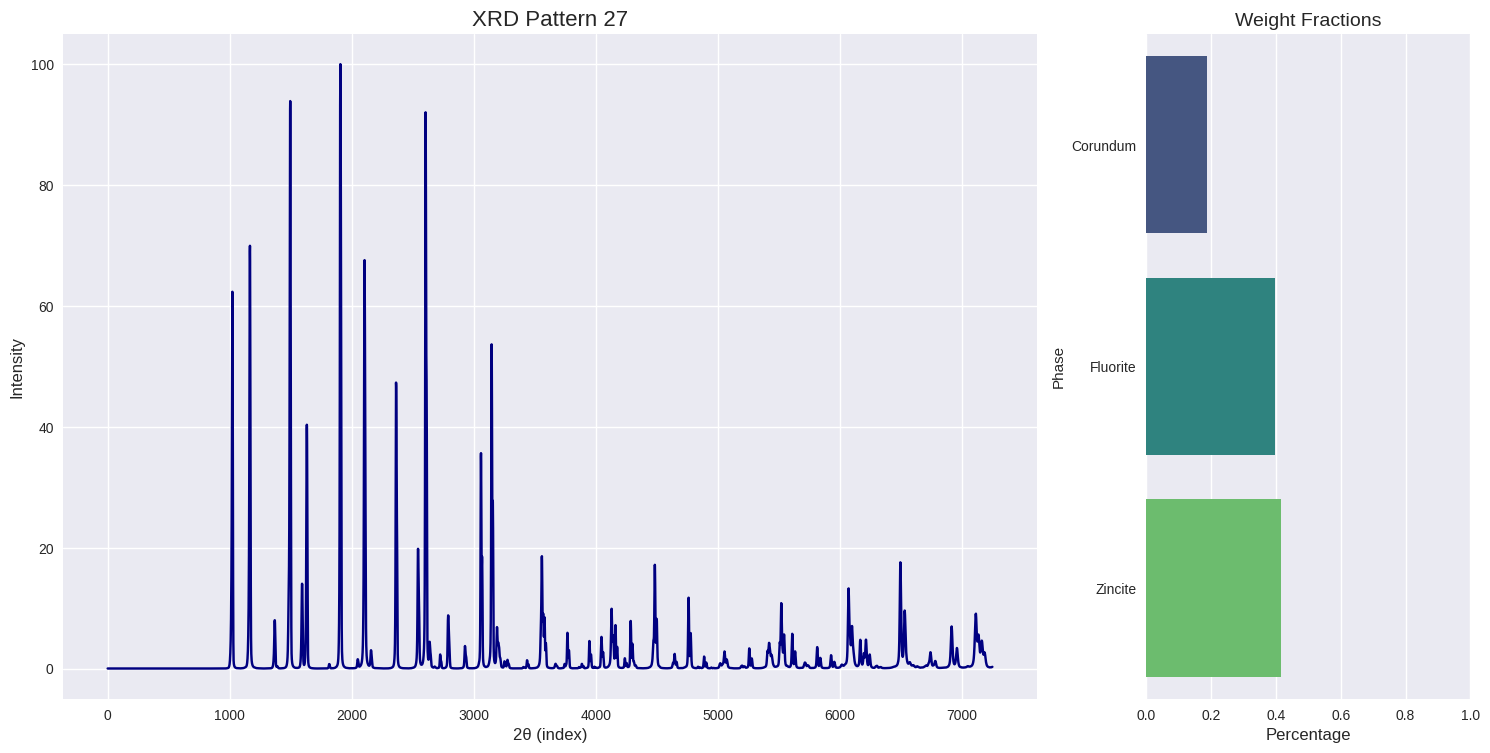

In [5]:
# TODO: 2 theta to degrees instead of index
# TODO: Add additional params?

# Create a fixed color map for all phases
all_phases = weight_fractions.columns.tolist()
color_palette = dict(zip(all_phases, sns.color_palette("viridis", len(all_phases))))

def plot_xrd_pattern(intensity, index, weight_fractions, additional_params, title=None):
    # Set up the matplotlib figure
    fig = plt.figure(figsize=(15, 10))
    gs = GridSpec(2, 2, width_ratios=[3, 1], height_ratios=[3, 1])
    
    # Plot XRD pattern
    ax_main = fig.add_subplot(gs[0, 0])
    ax_main.plot(range(len(intensity)), intensity, color='navy')
    ax_main.set_xlabel('2θ (index)', fontsize=12)
    ax_main.set_ylabel('Intensity', fontsize=12)
    if title:
        ax_main.set_title(title, fontsize=16)
    
    # Plot weight fractions as a horizontal bar chart
    ax_weight = fig.add_subplot(gs[0, 1])
    
    # Create a DataFrame with all phases, filling missing values with 0
    weight_df = pd.DataFrame({'Phase': all_phases, 
                              'Percentage': [weight_fractions.loc[index, phase] if phase in weight_fractions.columns else 0 
                                             for phase in all_phases]})
    
    # Sort by the global order of phases
    weight_df['Phase'] = pd.Categorical(weight_df['Phase'], categories=all_phases, ordered=True)
    weight_df = weight_df.sort_values('Phase')
    
    # Plot the bar chart
    sns.barplot(data=weight_df, x='Percentage', y='Phase', ax=ax_weight, hue='Phase', palette=color_palette, dodge=False, legend=False)     
    ax_weight.set_title('Weight Fractions', fontsize=14)
    ax_weight.set_xlabel('Percentage', fontsize=12)
    ax_weight.set_xlim(0, 1)
    
    plt.tight_layout()
    plt.show()

# Plot 3 random XRD patterns with phase information
for i in range(3):
    random_index = np.random.randint(0, len(intensities))
    plot_xrd_pattern(intensities[random_index], random_index, weight_fractions, additional_params, 
                     f"XRD Pattern {random_index}")

Look at distributions of randomised values.

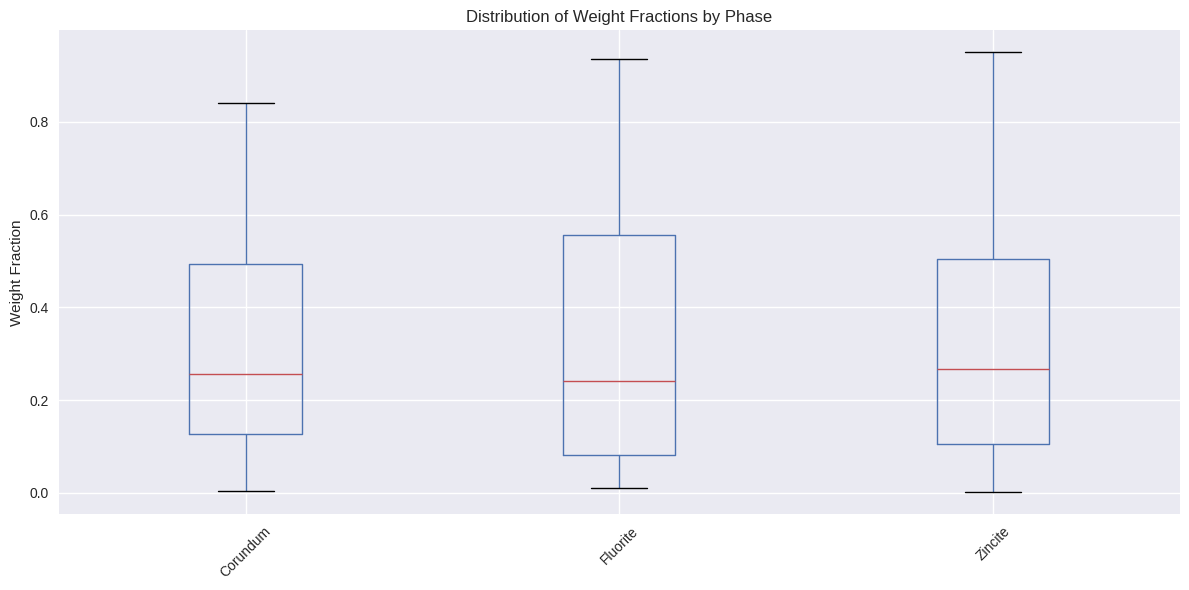

Average weight fractions:
Corundum    0.318214
Fluorite    0.339003
Zincite     0.342783
dtype: float64


In [6]:
plt.figure(figsize=(12, 6))
weight_fractions.boxplot()
plt.title('Distribution of Weight Fractions by Phase')
plt.ylabel('Weight Fraction')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate and print average weight fractions
avg_weight_fractions = weight_fractions.mean()
print("Average weight fractions:")
print(avg_weight_fractions)

In [13]:
# TODO: Visualise the distribution of the other parameters.

Analyse a trained model


Load the model

In [12]:
%%capture

# Import models you want to use
from src.models.smallFCN import smallFCN

# Choose which model to load and its type
model_path = 'trained_models/smallFCN_mae_0.2594_20241008_214038.pth'
model = smallFCN()

model.load_state_dict(torch.load(model_path))
model.eval()

Set inference params (Runs on the test set of the data_dir provided)

In [13]:
# Inference params
batch_size = 32 
num_workers = 4 

In [14]:
# Set up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Create data loaders
_, _, test_loader = create_data_loaders(
    data_dir,
    batch_size,
    num_workers
)

# Perform inference on the test set
all_predictions = []
all_targets = []

with torch.no_grad():
    for data, target, _ in test_loader:
        data = data.unsqueeze(1).to(device)
        output = model(data)
        all_predictions.append(output.cpu().numpy())
        all_targets.append(target.numpy())

predictions = np.concatenate(all_predictions)
targets = np.concatenate(all_targets)

FileNotFoundError: [Errno 2] No such file or directory: 'TOPAS_sim/simulations/test39/processed_data/additional_params.csv'

Prediction vs actual weights by phase

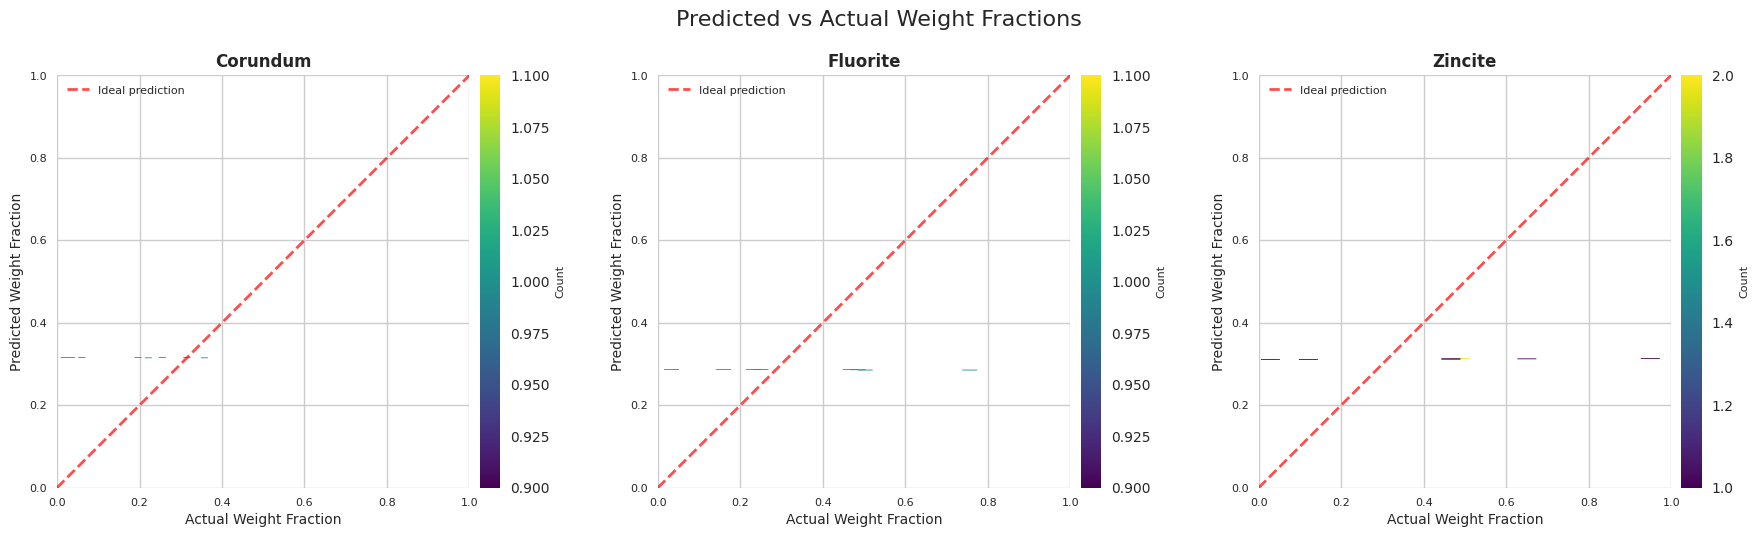

In [33]:
def plot_predictions_vs_actual(predictions, targets, phase_names):
    n_phases = predictions.shape[1]
    
    # Calculate the number of rows and columns for the subplots
    n_cols = min(3, n_phases)  # Maximum 3 plots per row
    n_rows = math.ceil(n_phases / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    fig.suptitle('Predicted vs Actual Weight Fractions', fontsize=16, y=1.02)
    
    # Set a clean, modern style
    sns.set_style("whitegrid")
    
    # Flatten the axes array if it's 2D
    if n_rows > 1:
        axes = axes.flatten()
    
    for i, (ax, phase) in enumerate(zip(axes, phase_names)):
        # Create a hexbin plot for density
        hb = ax.hexbin(targets[:, i], predictions[:, i], gridsize=20, cmap='viridis', mincnt=1)
        
        # Plot the diagonal line
        ax.plot([0, 1], [0, 1], 'r--', linewidth=2, alpha=0.7, label='Ideal prediction')
        
        # Set labels and title
        ax.set_xlabel('Actual Weight Fraction', fontsize=10)
        ax.set_ylabel('Predicted Weight Fraction', fontsize=10)
        ax.set_title(f'{phase}', fontsize=12, fontweight='bold')
        
        # Set limits and aspect
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_aspect('equal', adjustable='box')
        
        # Add a colorbar
        cb = plt.colorbar(hb, ax=ax, pad=0.02)
        cb.set_label('Count', fontsize=8)
        
        # Add legend
        ax.legend(loc='upper left', fontsize=8)
        
        # Adjust tick label size
        ax.tick_params(axis='both', which='major', labelsize=8)
    
    # Remove any unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

# Get phase names from the weight_fractions DataFrame
phase_names = weight_fractions.columns.tolist()

# Plot predictions vs actual values
plot_predictions_vs_actual(predictions, targets, phase_names)

In [34]:
# TODO: Do some more analysis

See how the model performs on Madsen Round Robin Samples

Run Madsen Round Robin Samples through the model


In [38]:
# Function to load and process XY files
def load_xy_file(file_path):
    data = np.loadtxt(file_path, skiprows=1)
    intensities = data[:, 1]  # Second column contains intensities
    # Normalize intensities to 100
    intensities = (intensities / np.max(intensities)) * 100
    return intensities

# Load and process XY files
sample_dir = 'analysis/Madsen_Round_Robin_2004/samples'
xy_files = [f for f in os.listdir(sample_dir) if f.endswith('.xy')]
xy_files.sort()  # Sort alphabetically to match weight_fractions.csv

intensities = []
for file in xy_files:
    intensity = load_xy_file(os.path.join(sample_dir, file))
    intensities.append(intensity)

# Convert to numpy array and reshape for the model
intensities = np.array(intensities)
intensities = intensities.reshape(intensities.shape[0], 1, -1)  # Add channel dimension

# Convert to torch tensor
intensities_tensor = torch.FloatTensor(intensities).to(device)

# Perform inference
model.eval()
with torch.no_grad():
    predictions = model(intensities_tensor)

# Convert predictions to numpy array
predictions = predictions.cpu().numpy()

# Load weight fractions
weight_fractions = pd.read_csv('analysis/Madsen_Round_Robin_2004/weight_fractions.csv')

Plot Madsen Samples

/tmp/ipykernel_3548265/2371470982.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_phase.set_yticklabels(ax_phase.get_yticklabels(), fontsize=8)
/tmp/ipykernel_3548265/2371470982.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_phase.set_yticklabels(ax_phase.get_yticklabels(), fontsize=8)
/tmp/ipykernel_3548265/2371470982.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_phase.set_yticklabels(ax_phase.get_yticklabels(), fontsize=8)
/tmp/ipykernel_3548265/2371470982.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_phase.set_yticklabels(ax_phase.get_yticklabels(), fontsize=8)
/tmp/ipykernel_3548265/2371470982.py:71: UserWarning: se

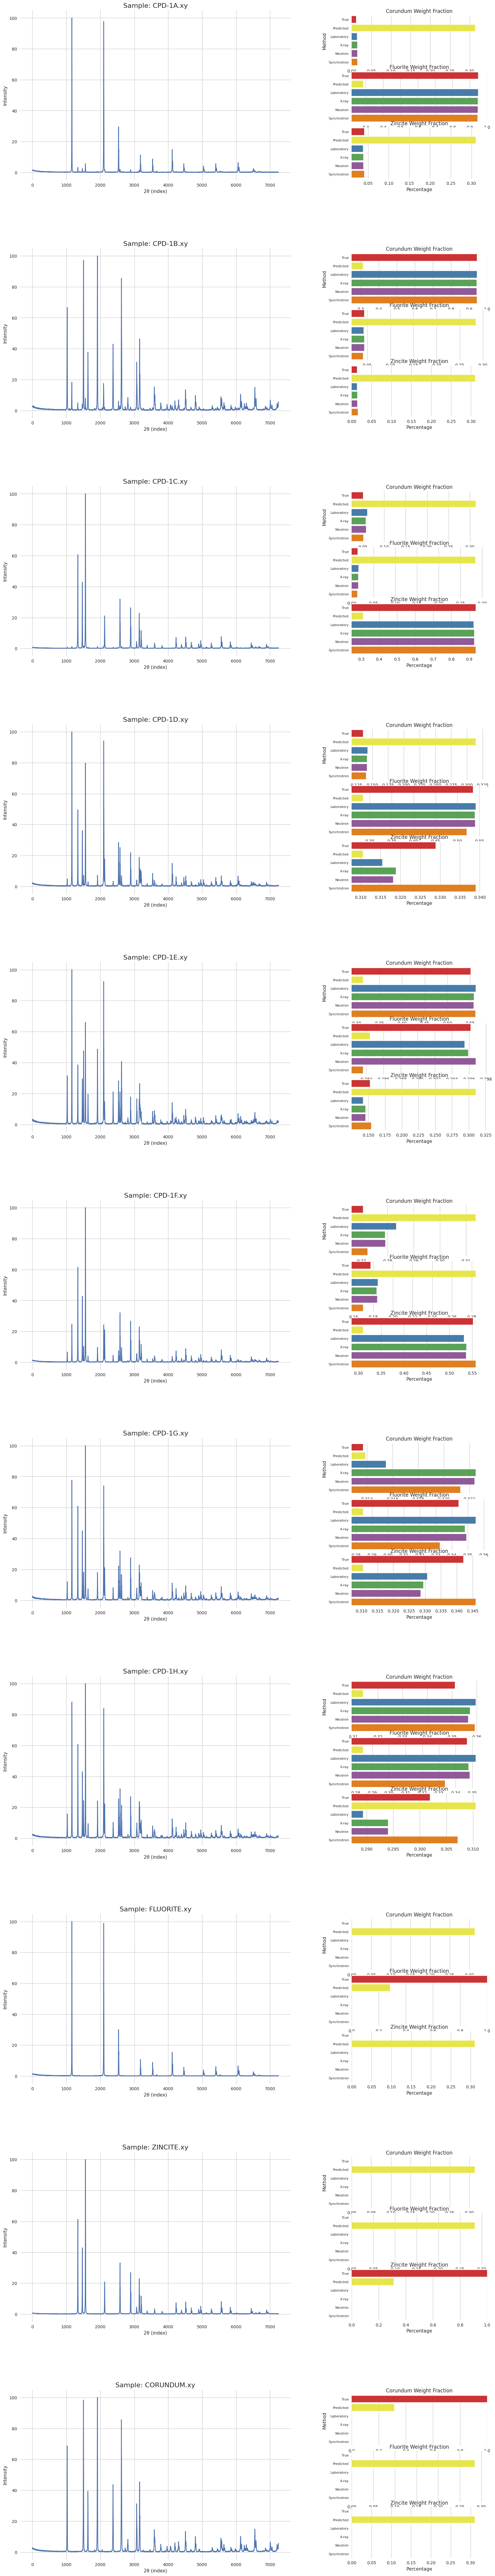

In [55]:
def plot_xrd_patterns(intensities, file_names, predictions, weight_fractions, num_plots=11):
    fig = plt.figure(figsize=(20, 10*num_plots))  # Increased figure height
    gs = fig.add_gridspec(num_plots, 2, width_ratios=[2, 1], height_ratios=[1]*num_plots, hspace=0.4, wspace=0.3)
    
    # Color scheme
    color_scheme = {
        'True': '#e41a1c',
        'Predicted': '#ffff33',
        'Laboratory': '#377eb8',
        'X-ray': '#4daf4a',
        'Neutron': '#984ea3',
        'Synchrotron': '#ff7f00'
    }
    
    # Load participant data
    participant_data = {
        method: pd.read_csv(f'analysis/Madsen_Round_Robin_2004/{method}_weight_fractions.csv')
        for method in ['CPD_analysis', 'X-ray', 'Neutron', 'Synchrotron']
    }
    
    # Reorder the samples to move the first one to the end
    plot_order = list(range(1, min(num_plots, len(intensities)))) + [0]
    
    for i, idx in enumerate(plot_order):
        # Plot XRD pattern
        ax_xrd = fig.add_subplot(gs[i, 0])
        ax_xrd.plot(intensities[idx][0])
        ax_xrd.set_title(f'Sample: {file_names[idx]}', fontsize=16)
        ax_xrd.set_xlabel('2θ (index)')
        ax_xrd.set_ylabel('Intensity')
        
        # Create subplot for phase percentages
        ax_phases = fig.add_subplot(gs[i, 1])
        ax_phases.axis('off')
        
        # Plot weight fractions for each phase
        for j, phase in enumerate(weight_fractions.columns):
            ax_phase = ax_phases.inset_axes([0, 0.67 - j*0.33, 1, 0.3])  # Adjusted positioning
            
            # Collect data for this phase
            data = {
                'True': weight_fractions.iloc[idx][phase],
                'Predicted': predictions[idx][j],
                'Laboratory': participant_data['Laboratory'].iloc[idx][phase],
                'X-ray': participant_data['X-ray'].iloc[idx][phase],
                'Neutron': participant_data['Neutron'].iloc[idx][phase],
                'Synchrotron': participant_data['Synchrotron'].iloc[idx][phase]
            }
            
            # Create DataFrame
            df = pd.DataFrame(list(data.items()), columns=['Method', 'Percentage'])
            
            # Plot
            sns.barplot(x='Percentage', y='Method', data=df, ax=ax_phase, 
                        hue='Method', palette=color_scheme, orient='h', legend=False)
            
            # Set title and labels
            ax_phase.set_title(f'{phase} Weight Fraction', fontsize=12)
            ax_phase.set_xlabel('Percentage')
            
            # Dynamically set x-axis limits
            min_val = df['Percentage'].min()
            max_val = df['Percentage'].max()
            range_val = max_val - min_val
            ax_phase.set_xlim(max(0, min_val - range_val * 0.1), 
                              min(1, max_val + range_val * 0.1))
            
            # Remove y-axis labels for all but the first phase plot
            if j > 0:
                ax_phase.set_ylabel('')
            ax_phase.set_yticklabels(ax_phase.get_yticklabels(), fontsize=8)
    
    plt.tight_layout()
    plt.show()

# Use the function as before
plot_xrd_patterns(intensities, xy_files, predictions, weight_fractions)